# Spaceship Titanic

Predict which passengers are transported to an alternate dimension

## Dataset Description
In this competition the task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help make these predictions, we are given a set of personal records recovered from the ship's damaged computer system.

### File and Data Field Descriptions

<ul>
<li><strong>train.csv</strong> - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.<ul>
<li><code>PassengerId</code> - A unique Id for each passenger. Each Id takes the form <code>gggg_pp</code> where <code>gggg</code> indicates a group the passenger is travelling with and <code>pp</code> is their number within the group. People in a group are often family members, but not always.</li>
<li><code>HomePlanet</code> - The planet the passenger departed from, typically their planet of permanent residence.</li>
<li><code>CryoSleep</code> - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.</li>
<li><code>Cabin</code> - The cabin number where the passenger is staying. Takes the form <code>deck/num/side</code>, where <code>side</code> can be either <code>P</code> for <em>Port</em> or <code>S</code> for <em>Starboard</em>.</li>
<li><code>Destination</code> - The planet the passenger will be debarking to.</li>
<li><code>Age</code> - The age of the passenger.</li>
<li><code>VIP</code> - Whether the passenger has paid for special VIP service during the voyage.</li>
<li><code>RoomService</code>, <code>FoodCourt</code>, <code>ShoppingMall</code>, <code>Spa</code>, <code>VRDeck</code> - Amount the passenger has billed at each of the <em>Spaceship Titanic</em>'s many luxury amenities.</li>
<li><code>Name</code> - The first and last names of the passenger.</li>
<li><code>Transported</code> - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.</li></ul></li>
<li><strong>test.csv</strong> - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of <code>Transported</code> for the passengers in this set. </li>
<li><strong>sample_submission.csv</strong> - A submission file in the correct format.<ul>
<li><code>PassengerId</code> - Id for each passenger in the test set.</li>
<li><code>Transported</code> - The target. For each passenger, predict either <code>True</code> or <code>False</code>.</li></ul></li>
</ul>

### Dependencies

First, we'll import the necessary libraries and import the data

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
# Laod data
train_data = pd.read_csv('Data/train.csv')
test_data = pd.read_csv('Data/test.csv')

## Step 1: Data Exploration and Cleaning

Now, we'll explore the data and clean it.

### 1.1 Summary statistics and data types
In this step, we compute summary statistics such as mean, standard deviation, and range for each numerical variable in our dataset. We also inspect the data types of each variable to ensure that they are correctly identified as numerical, categorical, or datetime. This helps us to understand the overall structure of the dataset and identify potential data quality issues such as missing values, incorrect data types, or extreme values that may need further investigation.

In [16]:
print(train_data.dtypes)
print(train_data.describe())

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object
               Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   8512.000000   8510.000000   8485.000000   8510.000000   
mean     28.827930    224.687617    458.077203    173.729169    311.138778   
std      14.489021    666.717663   1611.489240    604.696458   1136.705535   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      27.000000      0.000000      0.000000      0.000000      0.000000   
75%      38.000000     47.000000     76.000000     27.000000     59.000000   
max      79.000000  14327.

### 1.2 Data visualisation
In this step, we create visualizations such as histograms, box plots, and pairplots to explore the distribution of each variable and identify patterns or relationships between variables. Data visualization helps us to identify outliers, potential errors, and interesting patterns that may not be evident from summary statistics alone.

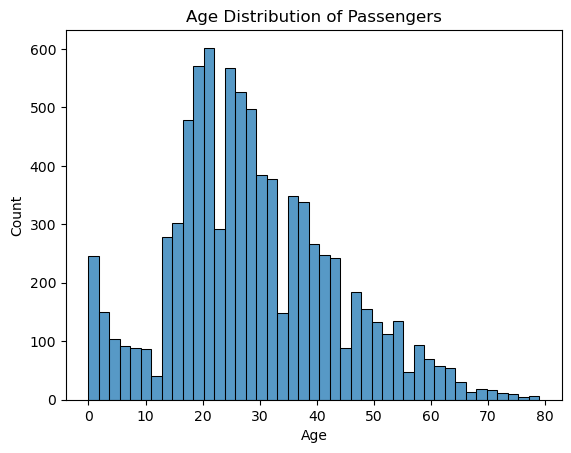

In [17]:
# Histogram of age distribution
sns.histplot(train_data['Age'])
plt.title('Age Distribution of Passengers')
plt.show()

__Explanation__: This histogram above shows the distribution of passengers' ages aboard the Spaceship Titanic. It helps us understand the age demographics of the passengers and identify any patterns or anomalies related to age.

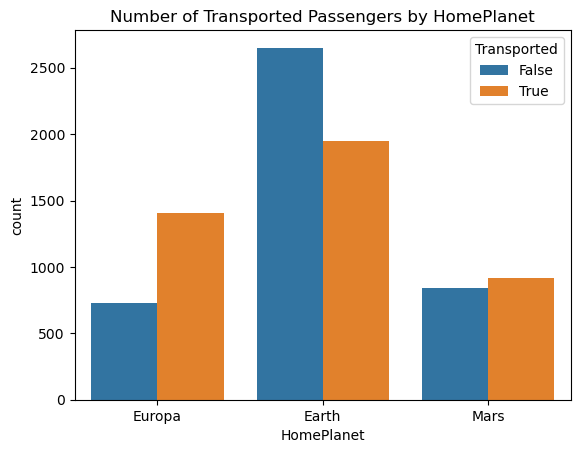

In [18]:
# Bar plot of HomePlanet vs Transported
sns.countplot(x='HomePlanet', hue='Transported', data=train_data)
plt.title('Number of Transported Passengers by HomePlanet')
plt.show()

__Explanation__: The bar plot above displays the number of transported and non-transported passengers for each HomePlanet. This visualization helps us identify if there is any relationship between a passenger's HomePlanet and the likelihood of being transported to another dimension.

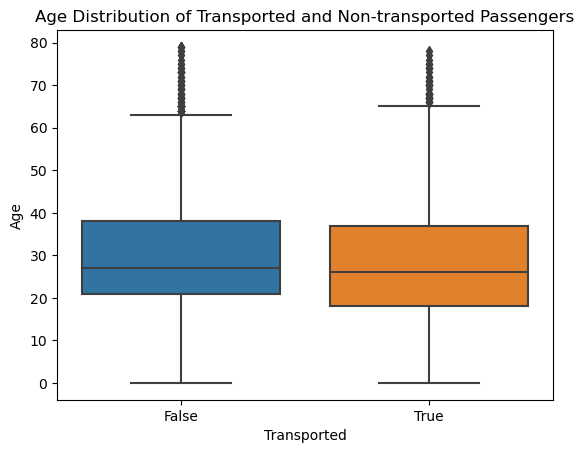

In [19]:
# Box plot of Age vs Transported
sns.boxplot(x='Transported', y='Age', data=train_data)
plt.title('Age Distribution of Transported and Non-transported Passengers')
plt.show()

__Explanation__: This box plot above shows the age distribution for transported and non-transported passengers. It helps us identify if there is any relationship between a passenger's age and their likelihood of being transported to another dimension.

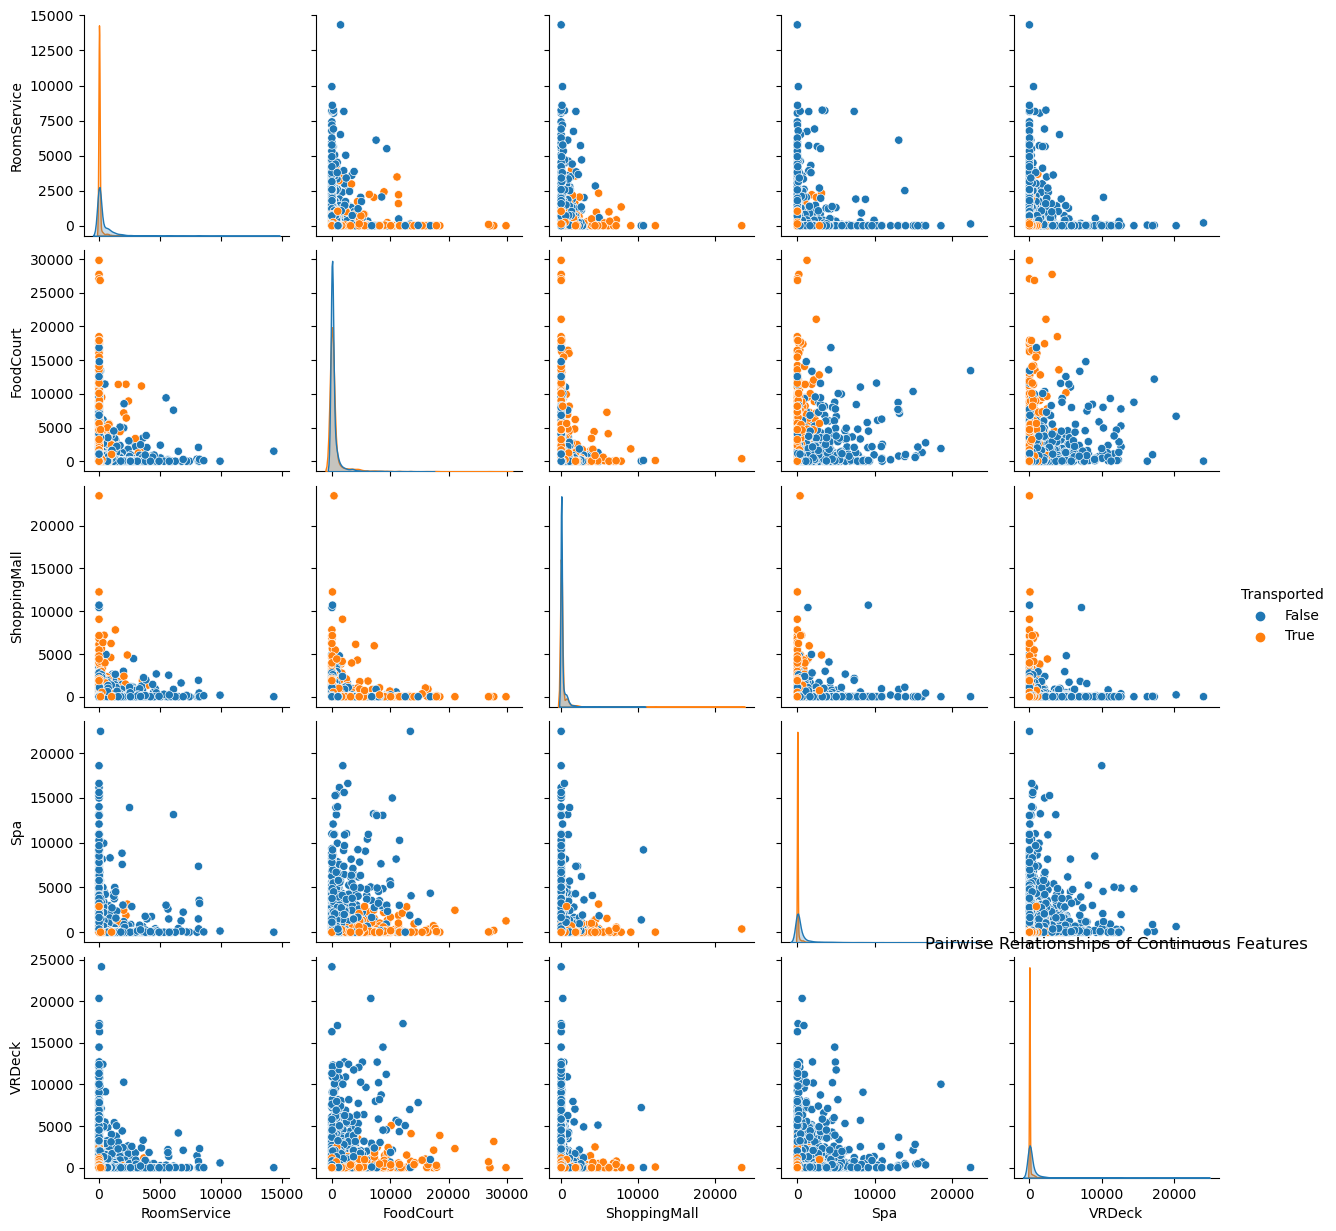

In [20]:
# Pairplot for continuous variables
sns.pairplot(train_data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported']], hue='Transported')
plt.title('Pairwise Relationships of Continuous Features')
plt.show()


__Explanation__: The pair plot illustrates the pairwise relationships between continuous features (RoomService, FoodCourt, ShoppingMall, Spa, and VRDeck) and their association with the target variable (Transported). It helps us identify patterns or correlations between the features, and aids in understanding which features might be important for predicting whether a passenger was transported to another dimension.

### 1.3 Outlier detection
In this step, we identify potential outliers or extreme values in our dataset that may indicate measurement errors or other data quality issues. Outliers can have a significant impact on statistical analysis and modeling, so it's important to identify and handle them appropriately.

In [27]:
# Check for outliers in continuous variables using the IQR method
def detect_outliers(data, columns):
    outlier_indices = []
    for column in columns:
        Q1 = data[column].quantile(0.1)
        Q3 = data[column].quantile(0.9)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        column_outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)].index
        outlier_indices.extend(column_outliers)
    return outlier_indices

outliers_to_remove = detect_outliers(train_data, ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'])

# Remove outliers if necessary
train_data = train_data.drop(outliers_to_remove, axis=0).reset_index(drop=True)


### 1.4 Correlation analysis
In this step, we explore the relationship between pairs of variables in our dataset. We calculate the correlation coefficient between each pair of numerical variables to measure the strength and direction of their relationship. Correlation analysis helps us to identify potential multicollinearity issues in our data, which can affect the performance of statistical models. It also helps us to identify interesting patterns or relationships between variables that may warrant further investigation.

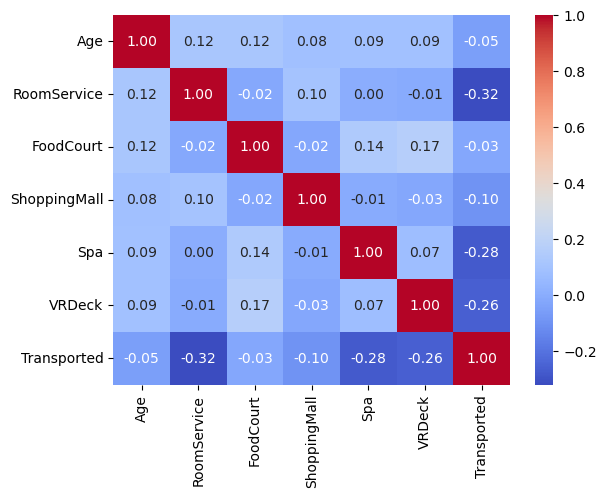

             RoomService       Spa    VRDeck  Transported
RoomService          NaN       NaN       NaN    -0.320649
Spa                  NaN       NaN       NaN    -0.275471
VRDeck               NaN       NaN       NaN    -0.261807
Transported    -0.320649 -0.275471 -0.261807          NaN


In [28]:
# Correlation matrix
corr_matrix = train_data.corr(numeric_only=True)

# Plot heatmap
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

# Find highly correlated features
threshold = 0.2
high_corr = corr_matrix[(abs(corr_matrix) > threshold) & (corr_matrix != 1.0)].dropna(how='all', axis=1).dropna(how='all', axis=0)
print(high_corr)
